<a href="https://colab.research.google.com/github/yashika-git/NLP/blob/main/Review_Based_QA_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# References:
# Book: Natural Language Processing with Transformers and accompanying code: https://github.com/nlp-with-transformers/notebooks/blob/main/07_question-answering.ipynb

In [24]:
# Work in progress

In [25]:
!pip -q install transformers
!pip -q install datasets

In [26]:
from datasets import get_dataset_config_names
import matplotlib.pyplot as plt

In [27]:
domains = get_dataset_config_names('subjqa') # To find out the subsets of dataset
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [28]:
# We'll be focussing on 'electronics' domain
from datasets import load_dataset
subjqa = load_dataset('subjqa', name='electronics')

Reusing dataset subjqa (/root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [30]:
# Flattening the nested columns with 'flatten' and converting the dataset to a pandas dataframe
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [31]:
dfs['train'].head()

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False]
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with s...","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]"


In [32]:
# Description of some relevant columns:

# title: The Amazon Standard Identification Number (ASIN) associated with each product
# question: The question
# answers.answer_text: The span of text in the review labeled by the annotator
# answers.answer_start: The start character index of the answer span
# context: The customer review

In [33]:
qa_cols = ['title', 'question', 'answers.text', 'answers.answer_start', 'context']
sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [34]:
# empty answers.text corresponds to the questions whose answers cannot be found in the reviews

In [35]:
# slicing out the span of the text in the review that correspond to the answer

#start_idx = sample_df["answers.answer_start"].iloc[0] returns an array, so we will index at 0 again
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
# sample_df["context"].iloc[0] returns the whole context
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

{'What': 236, 'How': 780, 'Is': 100, 'Does': 45, 'Do': 83, 'Was': 12, 'Where': 28, 'Why': 21}


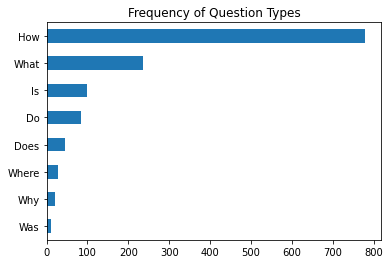

In [36]:
# counting the questions that begin with a few common starting words
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
print(counts)
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()  

In [37]:
# Looking at some questions beginning with "How", "What" and "Is"
# for question_type in ["How", "What", "Is"]:
# for question in (
# dfs["train"][dfs["train"].question.str.startswith(question_type)]
# .sample(n=3, random_state=42)['question']):
# print(question)

for question_type in ["How", "What", "Is"]:
  for question in (dfs['train'][(dfs['train']['question'].str.startswith(question_type))].sample(n=2)['question']):
    print(question)

    


How is the image quality like?
How is the quality?
What is the quality of room?
What is the price of the display?
Is the unit small?
Is the sound quality of the adapter proportional to the price?


In [38]:
# Extracting answers from text by framing the problem as a span classification task, where the start and end tokens of an
# answer span act as the labels that a model needs to predict.
# Using fine-tuned MiniLM Model, since it is fast to train

In [39]:
# Tokenizing text
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [40]:
# Trying to extract answer from a short passage
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending
on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [41]:
input_df = pd.DataFrame.from_dict(tokenizer(question), orient="index")
input_df

,0,1,2,3,4,5,6,7,8
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102
token_type_ids,0,0,0,0,0,0,0,0,0
attention_mask,1,1,1,1,1,1,1,1,1


In [42]:
input_df = pd.DataFrame.from_dict(tokenizer(context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
input_ids,101,2019,23378,2003,2055,1015,16914,1013,3371,1010,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
attention_mask,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [43]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df
# input_ids is the unique identifier for distinct tokens
# token_type_ids are 0 for question and 1 for context

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [44]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context))
input_df

,0
0,input_ids
1,token_type_ids
2,attention_mask


In [47]:
print(tokenizer.decode(inputs["input_ids"][0]))


[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [48]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)  

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [49]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [50]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [51]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])
